# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [1]:
import csv
# import os
import numpy as np
from numpy import linalg as la

import seaborn as sns
import matplotlib.pyplot as plt

We have also choosen to import matplotlib.pyplot and seaborn to visualize our results

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [2]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

Below is a sample of both train and test set:

In [3]:
print('TRAIN: {}'.format(data_train[0]))
print('TEST:  {}'.format(data_test[0]))

TRAIN: [-0.5798185   2.769459   50.         -1.38629436  0.         -1.38629436
  6.          0.         -0.4307829   1.        ]
TEST:  [ 0.73716407  3.473518   64.          0.61518564  0.         -1.38629436
  6.          0.          0.7654678   0.        ]


**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [4]:
M_train = data_train
M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k])
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set

In [5]:
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

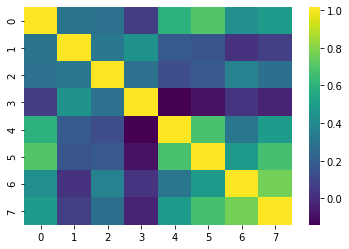

In [6]:
# Preliminary questions
AC = np.cov(M_train, rowvar=False)

sns.heatmap(AC, cmap='viridis')

The above figure is the autocovariance matrix computed from the train set, and visualized with a heatmap.

The autocovariance matrix (on columns) has values in $[-1, 1]$ and carries information on variables correlations:

The greater $|A_{i, j}|$ is, the more the variables $i$ and $j$ will be correlated, positively or negatively. If $|A_{i, j}| = 1$, the two variables are identical, ignoring a multiplication factor of the same sign as $A_{i, j}$. The closer $A_{i, j}$ is to $0$, the more the two variables will be independents.

It is then logical for $A$ to be symetrical, and for its diagonal to be filled with $1$.

Here we can see that among our 8 variables, none have a covariance of 1 nor -1, which means that all of our variables convey a different and complementary information. No two different variables have a covariance higher than 0.8.

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [7]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

We use the same procedure to buld $X_{train}$ than for $X_{test}$

In [8]:
t_train = data_train[:,8]   # target column
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train,1)), M_train[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

We create a function that returns $\hat{\beta}$ given $X$ and $t$, since we will use it again in the next exercise. $X$ and $t$ must both be np.array, for we use numpy's built-in functions

In [9]:
def beta_hat(X, t):
    return la.inv(X.T.dot(X)).dot(X.T).dot(t)

beta_hat_train = beta_hat(X_train, t_train)
print('beta_hat on train set: {}\n'.format(beta_hat_train))

print('mean train target: {:.8f}'.format(t_train.mean()))

beta_hat on train set: [ 2.45234509  0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025
 -0.28684075 -0.02075686  0.27526843]

mean train target: 2.45234509


Here `beta_hat[0] = 2.45`, which corresponds to target bias, i.e. the average output value, on the train set

We then create the following functions to compute predictions on $X_{test}$ given $\hat{\beta}$, and then get the error between the prediction and the ground truth.

In [10]:
def prediction(beta_hat_train, X_test):
    return X_test.dot(beta_hat_train)

def prediction_error(t_test, t_pred):
    return la.norm((t_test - t_pred))**2

t_pred = prediction(beta_hat_train, X_test)
prediction_error(t_test, t_pred)

15.638220165228017

In this case, we find an error of 15.64 on the test set

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

1. We now want to compute the Z-scores. To do so, we compute $\hat{\beta}$, then $t_{pred}$ to compute $\hat{\sigma}$, then $V$ and finally the Z-scores

In [11]:
p_train = X_train.shape[1]
# Compute Beta hat
beta_hat_train = beta_hat(X_train, t_train)
t_pred = np.dot(X_train, beta_hat_train)
# Compute Sigma hat
sigma_hat = np.sqrt(1 / (N_train - p_train - 1) * np.sum((t_pred - t_train)**2))
# Compute the V_js
V = np.sqrt(la.inv(X_train.T.dot(X_train)).diagonal())
# Divide Beta hat by Sigma hat
Z = beta_hat_train / V / sigma_hat

print('Z-scores:\n{}'.format(Z))

Z-scores:
[27.93752694  5.31982819  2.72697258 -1.38382296  2.03804576  2.44787594
 -1.85074859 -0.14541122  1.72279321]


2. We can now select the most meaningful variables only, i.e those whose z-score is greater or equals to 2, and get rid of the less meaningful variables by nullifyng their beta 

In [12]:
threshold=2
mask = (np.abs(Z) > threshold)
beta_z = mask * beta_hat_train

print('beta_hat when replacing least meaningful variables by 0:\n{}'.format(beta_z))

beta_hat when replacing least meaningful variables by 0:
[ 2.45234509  0.71104059  0.29045029 -0.          0.21041951  0.30730025
 -0.         -0.          0.        ]


We get an error of 13.57, which is lower than the one obtained previously with a regular least-sqare linear regression

In [13]:
t_pred = prediction(beta_z, X_test)
prediction_error(t_test, t_pred)

13.56679848219329

3. We follow the same idea, but this time removing the least meaningful variables before computing $\hat{\beta}$ instead of replacing them by 0 in the already-computed $\hat{\beta}$

In [14]:
threshold = 2
mask = (np.abs(Z) > threshold)
X_train_selected = np.array([x[mask] for x in X_train])
X_test_selected = np.array([x[mask] for x in X_test])
beta_hat_train_selected = beta_hat(X_train_selected, t_train)
print('beta_hat with only most meaningful variables according to the Z-scores:\n{}'.format(beta_hat_train_selected))
t_pred_selected = prediction(beta_hat_train_selected, X_test_selected)
prediction_error(t_test, t_pred_selected)

beta_hat with only most meaningful variables according to the Z-scores:
[2.45234509 0.62345    0.25488273 0.20339287 0.2800554 ]


13.689963661204871

We find a prediction error slightly higher to the one found at 2., but much lower than the one found at the Ex.1 without selection on Z-scores.

We can notice that the $\beta_j$ found here differ slightly from the ones computed previously. This makes sense, since the computation of $\beta$ involves a product of several  $X$ and $X^T$. $\beta_j$ depends on all $X_i$, even the least significants that will be nulled afterwards. If we delete them before the computation of $\beta$, these higher-order terms will not appear in the process and the result will therefore be different.

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [15]:
t = data_train[:,8]   # column of targets
t0 = np.mean(t)
t_c = t - t0

N_test = data_test.shape[0]
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))
# Here the 1st column of X_test is a column of ones.
beta_best = np.array([2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0])

We now implement the regularized linear least-square regression. The difference between this and the least-sqare regression is the regularization term, that penalize high regression coefficient, and aims at a better generalization capability. Also, it is important to exclude the bias from the computation of beta, we dont want to penalize the bias. This is why we use the matrix $M_{train}$, i.e. $X_{train}$ without the 1 column for the bias, and add the bias $t_0$ afterwards

In [16]:
def beta_hat_reg(X, t, lbd=25):
    d = X.shape[1]
    beta = la.inv(lbd*np.identity(d) + X.T.dot(X)).dot(X.T).dot(t)
    return np.concatenate([[t0], beta])

beta_hat_reg_train = beta_hat_reg(M_train, t_c)
print('Regularized beta_hat:\n{}'.format(beta_hat_reg_train))

Regularized beta_hat:
[ 2.45234509  0.4221092   0.24879171 -0.04226499  0.16575364  0.23091485
  0.01066329  0.04306017  0.13151316]


We now obtain an error of 14.82, which is lower than the error obtained without regularization (15.63). It is almost identical, however slightly higher than the error obtained with the "best beta" given above.

In [17]:
t_pred = prediction(beta_hat_reg_train, X_test)
prediction_error(t_test, t_pred)

14.818264797356152

In [18]:
t_pred = prediction(beta_best, X_test)
prediction_error(t_test, t_pred)

14.81060103332949

It is interesting to note that the error is higher than the one obtained doing feature selection with Z-scores (13.57).

# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [66]:
lmax = 40
lambda_pos = range(0,lmax+1) 
N_test = 10
erreur = np.zeros((6,lmax+1))

Implementing the cross validation requires us to wrap up most of what has been approached in this TP, making it a good exercise. 

After a quick initialization (shuffling the dataset, etc.), we loop on the number of cross-validation (here, 6). We then create the temporary test and train set from the initial train set, leaving the original test set aside to judge the final result afterwards. This dataset creation includes segmentation in test and train, normalization of both, isolation of $\beta_0$ and concatenation of the 1 column with the test set. Then, we loop over the parameter (lambda in range(0, 41)), perform regularized linear regression as coded in the Ex.3, test the performances on the temporary test set and store it for further comparison.

In [83]:
# Exercise 4 
def crossval(data_train, N_test, lambda_max=40):
    lambda_pos = range(0,lmax+1)
    erreur = np.zeros((6,lmax+1))
    data_train_shuffled = np.random.permutation(data_train)
    for p in range(6):   # loop on test subsets
        # extraction of testset
        testset  = data_train_shuffled[np.arange(p*N_test,(p+1)*N_test),0:9]
        t_test_tmp = testset[:, 8]
        # extraction of trainset
        trainset = data_train_shuffled[np.hstack((np.arange(p*N_test), range((p+1)*N_test,data_train_shuffled.shape[0]))),0:9] 
        # normalization of entries
        normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
        M_train_tmp = np.array( [ normalize(vec) for vec in trainset[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
        moy = np.array( [ np.mean(vec) for vec in trainset[:,0:8].T ] )
        sigma = np.array( [ np.std(vec) for vec in trainset[:,0:8].T ] )
        M_test_tmp = np.array([ (testset[:,k]-moy[k])/sigma[k] for k in range(M_train_tmp.shape[1]) ] ).T
        # t0
        t_tmp = trainset[:, 8]
        t0_tmp = np.mean(t_tmp)
        t_c_tmp = t_tmp - t0_tmp
        # X_test
        X_test_tmp = np.hstack((np.ones((N_test,1)), M_test_tmp[:,0:8]))
        # beta_hat
        for lbd in lambda_pos:
            beta_hat_reg_train = beta_hat_reg(M_train_tmp, t_c_tmp, lbd=lbd)
            # Evaluation
            t_pred = prediction(beta_hat_reg_train, X_test_tmp)
            err = prediction_error(t_test_tmp, t_pred)
            erreur[p, lbd] = err
            # print('    lambda: {} erreur: {}'.format(lbd, err))
    return erreur

First of all, we can see a great volatility in the results. The total train set contains 67 examples, and is separated into a temporary train set of size 57 and a test set of size 10. Given the little size of the test set and the fact that we shuffle data beforehand, it is normal to see such a deviation in the results from time to time, with the same hyperparameters.

best lambda: 18


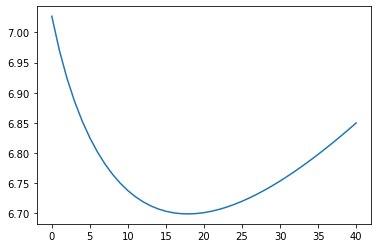

In [97]:
erreur = crossval(data_train, 10)
erreur_avg = [np.mean(x) for x in erreur.T]
plt.plot(erreur_avg)
best_lbd = np.where(erreur_avg == np.amin(erreur_avg))[0][0]
print('best lambda: {}'.format(best_lbd))

best lambda: 2


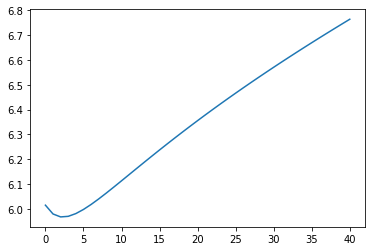

In [99]:
erreur = crossval(data_train, 10)
erreur_avg = [np.mean(x) for x in erreur.T]
plt.plot(erreur_avg)
best_lbd = np.where(erreur_avg == np.amin(erreur_avg))[0][0]
print('best lambda: {}'.format(best_lbd))

We can also see that between the 6 cross-validation samples, the difference of the error is great, with a standard seviation per lambda between 1 and 2

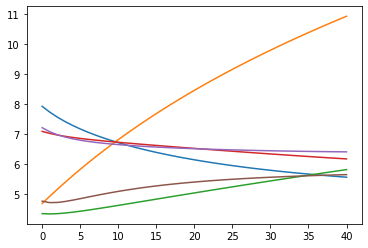

In [100]:
plt.plot(erreur.T)

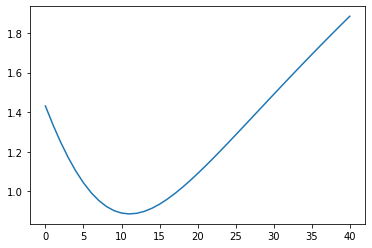

In [101]:
erreur_std = [x.std() for x in erreur.T]
plt.plot(erreur_std)

To get a better idea of the optimal lambda, we can iterate the process several times (here, 20) to get a better estimation of the best lambda value. We obtain a mean best lambda of 5.35 on 20 iterations, with a standard deviation between different tries of 5.75. This is quite a high standard deviation.
The obtained error with this lambda is slightly lower than the one obtained with an arbitrary lambda of 25 on the same test set (14.799 vs 14.818).

In [102]:
N_it = 20
res = []
for i in range(N_it):
    erreur = crossval(data_train, 10)
    erreur_avg = [np.mean(x) for x in erreur.T]
    best_lbd = np.where(erreur_avg == np.amin(erreur_avg))[0][0]
    res.append(best_lbd)
print('Mean best lambda on {} iterations: {:.2f}'.format(N_it, np.mean(res)))
print('Standard Deviation of best lambda on {} iterations: {:.2f}'.format(N_it, np.std(res)))
best_lbd = np.mean(res)

Mean best lambda on 20 iterations: 5.35
Standard Deviation of best lambda on 20 iterations: 5.75


In [103]:
beta_hat_reg_train = beta_hat_reg(M_train, t_c, lbd = best_lbd)
t_pred = prediction(beta_hat_reg_train, X_test)
prediction_error(t_test, t_pred)

14.799331477003646

However, when trying different values of lambda, we realized than the "optimal lambda" found with the cross validation is not the best. A lambda twice as high obtains better results (14.618 vs 14.799). It is not surprising that we haven't found the best lambda, given the small size of the test sets during the cross-validation. It seems logical that such a small number could not represent the whole data distribution and is, therefore, a poor test set.

In [75]:
beta_hat_reg_train = beta_hat_reg(M_train, t_c, lbd = 12)
t_pred = prediction(beta_hat_reg_train, X_test)
prediction_error(t_test, t_pred)

14.61818221113153